In [2]:
from tqdm import tqdm
import pandas as pd
import re
np = pd.np
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from collections import Counter

# The Stanford Politeness Corpus

In [2]:
HDF_FPATH = 'Stanford_politeness_corpus/fromJson.hdf'

## Tokens

In [ ]:
print('Preparing tokenized data...')
try:
    tokens = pd.read_hdf(HDF_FPATH, 'token')
    print('Successfully loaded!')
except:
    from tqdm import tqdm
    from ekphrasis.classes.preprocessor import TextPreProcessor
    from ekphrasis.classes.tokenizer import SocialTokenizer

    text_processor = TextPreProcessor(
        # terms that will be normalized
        normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'url', 'date', 'number'],
        # terms that will be annotated
        annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'},
        unpack_hashtags=False,  # perform word segmentation on hashtags
        unpack_contractions=True,  # Unpack contractions (can't -> can not)
        tokenizer=SocialTokenizer(lowercase=True).tokenize,)

    def tokenize(s):
        pbar.update()
        return text_processor.pre_process_doc(s)
    with tqdm(total=len(text_feats_2scores_df), desc='Tokenize') as pbar: tokens = text_feats_2scores_df.text.apply(tokenize).rename('token')
    tokens.to_hdf(HDF_FPATH, 'token')
    print('Successfully prepared!')
token_cnts = tokens.apply(Counter)

## LIWC Vectors

In [ ]:
liwc_en_df = pd.read_csv('lexica/liwc_en.csv', index_col=0)
liwc_en_df['ifWildcard'] = liwc_en_df['term'].str.endswith('*')
liwc_en_df['term'] = liwc_en_df['term'].str.rstrip('*')
convertToNestedDict = lambda _: {i: _.xs(i).to_dict() for i in _.index.levels[0]} # https://stackoverflow.com/a/42151082/1147061
_ = liwc_en_df.groupby(['category', 'ifWildcard']).term.unique().apply(set)
liwc_en = convertToNestedDict(_)

from collections import Counter
def countTokenByList(tkns, liwc=liwc_en):
    pbar.update()
    cnts = Counter(tkns)
    res  = dict()
    for category, sub_dict in liwc.items():
        res[category] = sum(cnts[i] for i in sub_dict[False].intersection(cnts)) # simple_tkns
        if True not in sub_dict: continue
        for j, v in cnts.items():
            for i in sub_dict[True]: # wildcard_tkns
                if j.startswith(i):
                    res[category] += v
    return pd.Series(res)

with tqdm(tokens) as pbar: liwc_cnts = tokens.apply(countTokenByList)
liwc_cnts.to_hdf(HDF_FPATH, 'liwc_vecs_df')

## EmoLex Vectors

In [ ]:
def _(cnts, nrc_df=nrc_en_df):
    pbar.update()
    cnts = pd.Series(cnts)
    return (nrc_df.reindex(cnts.index).T*cnts).T.sum().astype(int)
with tqdm(token_cnts) as pbar:
    nrc_cnts_df = token_cnts.apply(_, nrc_df=nrc_en_df)

In [ ]:
# Save to HDF:
nrc_cnts_df.to_hdf(HDF_FPATH, 'nrc_vecs_df')

## PoliteLex Vectors

In [ ]:
texts = tokens.apply(' '.join).str.replace(r'`.*?`', '', regex=True).str.replace(r' ?</?[a-z]*> ?', '.', regex=True)
my_feats_df = extractFeaturesFromCorpus(texts, token_cnts, rule_lang='rule_en')

In [ ]:
# Save to HDF:
my_feats_df.to_hdf(HDF_FPATH, 'polite_cnts_df')

# Microblogs

In [12]:
HDF_FPATH = 'data_200516.hdf' # Weibo = 3245+3000 -> 6226 ; Twitter = 3083+3000 -> 5375

## Tokens

In [13]:
weibo_df = pd.read_csv('AnnotateWeibo/Weibo2014_3245+3000.csv').set_index(['sid', 'RT_level'])
twitr_df = pd.read_csv('AnnotateTwitr/Twitr2014_3083+3000.csv').set_index('sid')

In [8]:
def extractFromPattern(text, pattern, return_original_text_on_fail=True, capture_group_id=1):
    m = pattern.search(text)
    if m:
        return m.group(capture_group_id)
    elif return_original_text_on_fail:
        return text

try:
    twitr_tokens = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_token')
    print(f'Loaded {len(twitr_tokens)} entries from HDF repository!')
except:
    print('Building tokenized versions of posts...')
    #!pip install ekphrasis
    from ekphrasis.classes.preprocessor import TextPreProcessor
    from ekphrasis.classes.tokenizer import SocialTokenizer
    text_processor = TextPreProcessor(
        # terms that will be normalized
        normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'url', 'date', 'number'],
        # terms that will be annotated
        annotate={}, #{"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'},
        unpack_hashtags=False,  # perform word segmentation on hashtags
        unpack_contractions=False,  # Unpack contractions (can't -> can not)
        tokenizer=SocialTokenizer(lowercase=True).tokenize,)

    def tokenize(s):
        pbar.update()
        tokens = text_processor.pre_process_doc(s)
        # Remove the "RT <user> :" part:
        if tokens[:3]==['rt', '<user>', ':']:
            tokens = tokens[3:]
        return tokens
    with tqdm(total=len(twitr_df), desc='Tokenize') as pbar: 
        twitr_tokens = twitr_df['text'].apply(tokenize).rename('token')

    twitr_tokens.to_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_token')
    print(f'Saved {len(twitr_tokens)} entries to HDF repository!')

try:
    weibo_tokens = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_token')
    print(f'Loaded {len(weibo_tokens)} entries from HDF repository!')
except:
    print('Building tokenized versions of posts...')

    automated_reply_pattern = re.compile(r'^回复 {AT} .+?】的评论："(.+)"查看原文：🔗网页链接$')
    reply_pattern = re.compile(r'^回复 {AT} :(.+)')
    
    ## Segmentize posts. Code in this cell is essentially copy & pasted from `/data/myli/emoji/corpora/prepare_training_data.py`.
    #!conda install -c conda-forge cysignals -y # dependency of pyfasttext
    #!pip install jieba_fast emoji hanziconv pyfasttext
    import jieba_fast
    from weibo_cleaner import mask
    from tqdm import tqdm

    exploded_marker_pattern = re.compile(' { ([A-Z]{2}) } ')

    # Clean text:
    weibo_raw_texts = weibo_df['text']
    weibo_masked_texts = weibo_raw_texts.apply(mask)
    weibo_cleaned_texts = weibo_masked_texts
    weibo_cleaned_texts = weibo_cleaned_texts.apply(extractFromPattern, pattern=automated_reply_pattern)
    weibo_cleaned_texts = weibo_cleaned_texts.apply(extractFromPattern, pattern=reply_pattern)

    # Now we are in the list-of-tokens space:
    def segmentize(text, pbar):
        '''Converts a string into a list of strings.'''
        pbar.update()
        jieba_tokens = jieba_fast.cut(text)
        jieba_tokenized_text = ' '.join(jieba_tokens)
        fixed_string = exploded_marker_pattern.sub(r'{\1}', ' '+jieba_tokenized_text+' ').strip() # fix exploded markers
        return fixed_string.split(' ')
    with tqdm(total=len(weibo_cleaned_texts), desc='Segmentize Weibo posts') as pbar: 
        weibo_all_tokens = weibo_cleaned_texts.apply(segmentize, pbar=pbar)
        
    def cleanUp(tokens, pbar):
        '''Clean up a list of tokens by removing unwanted, meaningless tokens.'''
        pbar.update()
        tokens = filter(None, tokens) # Remove empty tokens
        tokens = filter(lambda token: token!='{SP}', tokens) # Remove space tokens
        return list(tokens)
    with tqdm(total=len(weibo_all_tokens), desc='Clean up Weibo posts') as pbar: 
        weibo_cleaned_tokens = weibo_all_tokens.apply(cleanUp, pbar=pbar)

    weibo_tokens = weibo_cleaned_tokens.rename('token')

    # Save to file:
    weibo_tokens.to_hdf(HDF_FPATH, 'Weibo2014_3245+3000_token')
    print(f'Saved {len(weibo_tokens)} entries to HDF repository!')

Loaded 5375 entries from HDF repository!
Building tokenized versions of posts...


Segmentize Weibo posts:   0%|          | 0/6226 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "<ipython-input-8-c7b6210c2f02>", line 39, in <module>
    weibo_tokens = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_token')
  File "/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/pandas/io/pytables.py", line 407, in read_hdf
    return store.select(key, auto_close=auto_close, **kwargs)
  File "/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/pandas/io/pytables.py", line 757, in select
    raise KeyError("No object named {key} in the file".format(key=key))
KeyError: 'No object named Weibo2014_3245+3000_token in the file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/jieba

Saved 6226 entries to HDF repository!


/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


### Preview tokens

In [9]:
twitr_tokens

sid
492077708252151808    [actually, ready, for, school, to, start, back...
484345814979203073     [distilled, water, has, a, funny, taste, to, it]
494326161368166400          [", <user>, :, <url>, <user>, hahahahahaha]
484301971927887872    [queensland, aus, cairns, », <url>, <number>, ...
484402308092923904    [forever, hating, comcast, network, for, not, ...
                                            ...                        
422576337736302592                              [pound, it, bro, <url>]
485154577453711360    [🐧, ⛄, ️, 🐧, ⛄, ️, 🐧, hi, luke, hemmings, from...
487328065815449601    [🔆, 💕, 🔆, 💕, 🔆, 💕, 🔆, 💕, <user>, hi, luke, fro...
422496885035634688    [<user>, hiii, greg, :), i, ', m, really, sorr...
454426594644221952    [one, of, my, favorite, guitar, players, <user...
Name: token, Length: 5375, dtype: object

In [10]:
weibo_tokens

sid               RT_level
3703569989511011  1           [第一段, ：, 经常, 上, 天涯, 看, （, 婆媳, 大战, 、, 母子, 关系, 、...
3694122940089227  3           [呵呵, ，, 你, 不会, 以为, 中国, 搜寻, 飞机, 是从, 中国, 起飞, 的, ...
3745219256257320  2           [早晚, 的, 事, ，, 但, 他, 忽视, 了, 一个, 重要, 问题, —, —, 【...
3691292627832848  2           [呵, …, …, 有, 时间, 会, 补眠别, 担心, ，, 有, 空闲, 时间, 也, ...
3717359665330839  2           [{TP}, 抱歉, 抱歉, ！, 昨天, 交了, 一遍, 稿, ，, 可能, 是, 半夜,...
                                                    ...                        
3683247063733501  2           [谢谢您, 支持, ！, 新浪, 和, 网络, 要, 奖励, 那些, 无偿, 写出, 那么,...
3739886810577395  0           [回复, {AT}, 【, 诗歌, ：, 偶想, 】, 的, 评论, ：, ", {TP},...
3752126586912077  0           [回复, {AT}, 对, 博文, 【, 散文, ：, 故乡, 的, 房子, 】, 的, 评...
3741321527205730  0           [回复, {AT}, 【, 小小说, ：, 规矩, 】, 的, 评论, ：, ", {TP}...
3710791964277578  1           [再次, 致歉, 并, 为, 您, 的, 气度, 所, 折服, ！, 从, “, 被, 获奖...
Name: token, Length: 6226, dtype: object

## LIWC Vectors

### LIWC Term Counts

In [14]:
convertToNestedDict = lambda _: {i: _.xs(i).to_dict() for i in _.index.levels[0]} # https://stackoverflow.com/a/42151082/1147061
def convertCsvLiwcToNestedDict(csvpath = '../emoji/lexica/liwc.csv'):
    '''
    '''
    liwc_df = pd.read_csv(csvpath)
    liwc_df['ifWildcard'] = liwc_df['term'].str.endswith('*')
    liwc_df['term'] = liwc_df['term'].str.rstrip('*')
    _ = liwc_df.groupby(['category', 'ifWildcard']).term.unique().apply(set)
    return convertToNestedDict(_)
liwc_en = convertCsvLiwcToNestedDict('lexica/liwc_en.csv')
liwc_cn = convertCsvLiwcToNestedDict('lexica/liwc_cn.csv')
from collections import Counter
def countTokenByList(tkns, liwc):
    pbar.update()
    cnts = Counter(tkns)
    res  = dict()
    for category, sub_dict in liwc.items():
        res[category] = sum(cnts[i] for i in sub_dict[False].intersection(cnts)) # simple_tkns
        if True not in sub_dict: continue
        for j, v in cnts.items():
            for i in sub_dict[True]: # wildcard_tkns
                if j.startswith(i):
                    res[category] += v
    return pd.Series(res

In [15]:
try:
    twitr_liwc_cnts_df = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_liwc_cnts_df')
    print(f'Loaded {len(twitr_liwc_cnts_df)} entries from HDF repository!')
except:
    print('Counting tokens for each LIWC category in each post...')
    with tqdm(twitr_tokens) as pbar: 
        twitr_liwc_cnts_df = twitr_tokens.apply(countTokenByList, liwc=liwc_en)
    twitr_liwc_cnts_df.to_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_liwc_cnts_df')
    print(f'Saved {len(twitr_liwc_cnts_df)} entries to HDF repository!')    

try:
    weibo_liwc_cnts_df = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_liwc_cnts_df')
    print(f'Loaded {len(weibo_liwc_cnts_df)} entries from HDF repository!')
except:
    print(f'Counting tokens for each LIWC category in each post...')
    with tqdm(weibo_tokens) as pbar: 
        weibo_liwc_cnts_df = weibo_tokens.apply(countTokenByList, liwc=liwc_cn)
    weibo_liwc_cnts_df.to_hdf(HDF_FPATH, 'Weibo2014_3245+3000_liwc_cnts_df')
    print(f'Saved {len(weibo_liwc_cnts_df)} entries to HDF repository!')

Loaded 5375 entries from HDF repository!
Loaded 6226 entries from HDF repository!


In [17]:
twitr_liwc_cnts_df

,Achieve,Adj,Adverb,Affect,Affiliation,Anger,Anx,Article,Assent,Auxverb,...,Social,Space,Swear,Tentat,They,Time,Verb,We,Work,You
sid,,,,,,,,,,,,,,,,,,,,,
492077708252151808,0,0,2,1,0,0,0,0,0,0,...,0,1,0,0,0,2,1,0,1,0
484345814979203073,0,1,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
494326161368166400,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
484301971927887872,0,1,0,1,0,0,0,2,0,0,...,0,0,0,1,0,1,0,0,0,0
484402308092923904,0,0,0,1,1,1,0,0,0,0,...,1,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422576337736302592,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
485154577453711360,0,0,1,2,1,0,0,1,0,1,...,2,0,0,0,0,0,3,0,0,1
487328065815449601,0,2,0,4,3,0,0,0,1,0,...,4,0,0,0,0,0,2,0,0,1


#### Simple stats (optional)

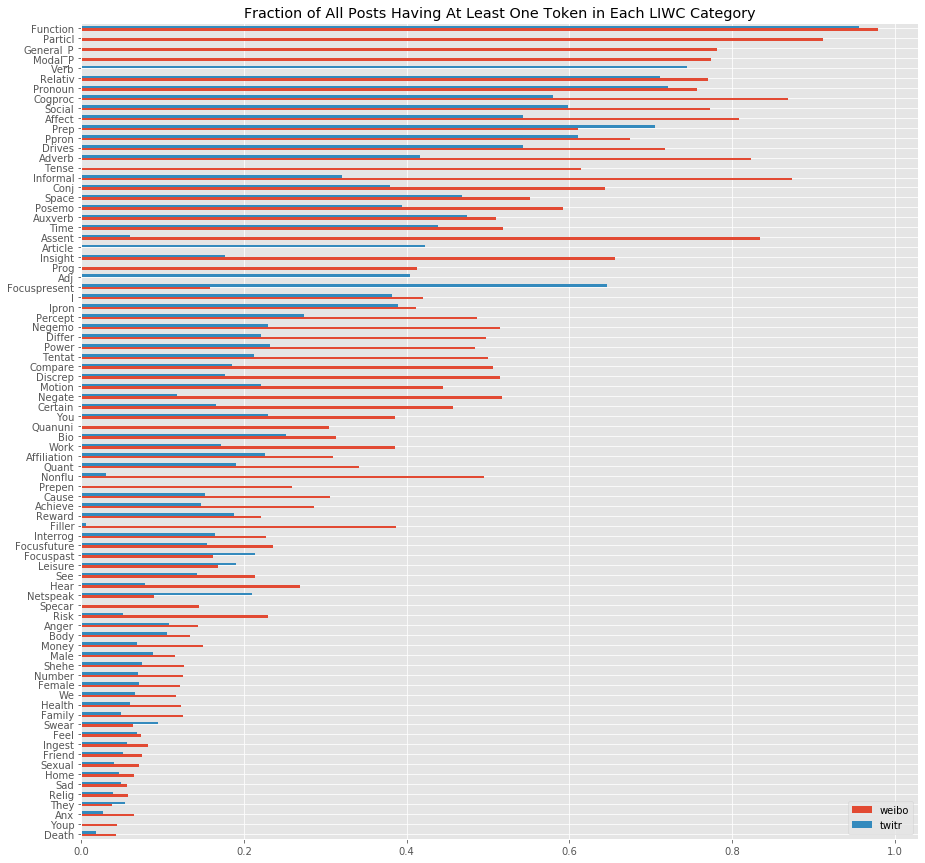

In [13]:
twitr_liwc_ifFound_df = twitr_liwc_cnts_df>0
twitr_liwc_ifFound_vc_df = twitr_liwc_ifFound_df.apply(pd.Series.value_counts).T
twitr_liwc_ifFound_vc_df.sort_values(True, inplace=True)

weibo_liwc_ifFound_df = weibo_liwc_cnts_df>0
weibo_liwc_ifFound_vc_df = weibo_liwc_ifFound_df.apply(pd.Series.value_counts).T
weibo_liwc_ifFound_vc_df.sort_values(True, inplace=True)

liwc_ifFound_ratio_df = pd.DataFrame({
    'weibo': ((weibo_liwc_cnts_df>0).sum()/len(weibo_liwc_cnts_df)),
    'twitr': ((twitr_liwc_cnts_df>0).sum()/len(twitr_liwc_cnts_df)),})
liwc_ifFound_ratio_df = liwc_ifFound_ratio_df.reindex(liwc_ifFound_ratio_df.T.mean().sort_values().index)
liwc_ifFound_ratio_df.plot.barh(figsize=(15,15), title='Fraction of All Posts Having At Least One Token in Each LIWC Category');

### Convert LIWC term counts into TF-IDF

In [14]:
try:
    twitr_liwc_tfidf_df = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_liwc_tfidf_df')
    print(f'Loaded {len(twitr_liwc_tfidf_df)} entries from HDF repository!')
except:
    print(f'Computing TF-IDF from LIWC counts...')
    twitr_num_tokens      = twitr_tokens.apply(len)
    twitr_liwc_tfs_df     = (twitr_liwc_cnts_df.T/twitr_num_tokens).T
    twitr_liwc_ifFound_df = twitr_liwc_cnts_df>0
    twitr_liwc_idfs       = np.log(len(twitr_tokens) / (twitr_liwc_ifFound_df).sum())
    twitr_liwc_tfidf_df   = twitr_liwc_tfs_df*twitr_liwc_idfs
    twitr_liwc_tfidf_df.to_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_liwc_tfidf_df')
    print(f'Saved {len(twitr_liwc_tfidf_df)} entries to HDF repository!') 

Computing TF-IDF from LIWC counts...
Saved 5375 entries to HDF repository!


/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'TwtUs2014_3083+3000_liwc_tfidf_df'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [15]:
try:
    weibo_liwc_tfidf_df = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_liwc_tfidf_df')
    print(f'Loaded {len(weibo_liwc_tfidf_df)} entries from HDF repository!')
except:
    print(f'Computing TF-IDF from LIWC counts...')
    weibo_num_tokens      = weibo_tokens.apply(len)
    weibo_liwc_tfs_df     = (weibo_liwc_cnts_df.T/weibo_num_tokens).T
    weibo_liwc_ifFound_df = weibo_liwc_cnts_df>0
    weibo_liwc_idfs       = np.log(len(weibo_tokens) / (weibo_liwc_ifFound_df).sum())
    weibo_liwc_tfidf_df   = weibo_liwc_tfs_df*weibo_liwc_idfs
    weibo_liwc_tfidf_df.to_hdf(HDF_FPATH, 'Weibo2014_3245+3000_liwc_tfidf_df')
    print(f'Saved {len(weibo_liwc_tfidf_df)} entries to HDF repository!') 

Computing TF-IDF from LIWC counts...
Saved 6226 entries to HDF repository!


/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Weibo2014_3245+3000_liwc_tfidf_df'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


#### Simple stats (optional)

In [16]:
# liwc term counts:
countLiwcTermsInEachCtgy = lambda d: pd.Series({k: len(v[False])+(len(v[True]) if True in v else 0) for k, v in d.items()})
liwc_cn_termCnts = countLiwcTermsInEachCtgy(liwc_cn).rename('weibo')
liwc_en_termCnts = countLiwcTermsInEachCtgy(liwc_en).rename('twitr')

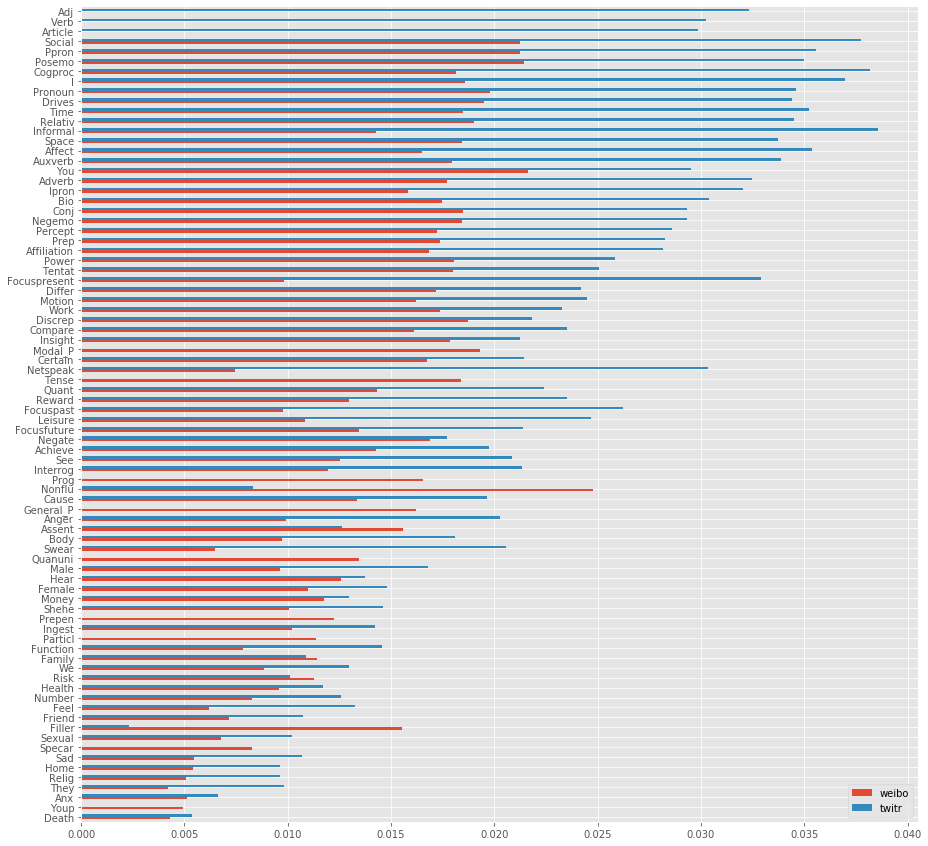

In [17]:
# liwc TF-IDF ratiostwitr_token_cnts:
liwc_tfidf_ratio_df = pd.DataFrame({
    'weibo': (weibo_liwc_tfidf_df.sum()/len(weibo_liwc_cnts_df)),
    'twitr': (twitr_liwc_tfidf_df.sum()/len(twitr_liwc_cnts_df)),})
liwc_tfidf_ratio_df = liwc_tfidf_ratio_df.reindex(liwc_tfidf_ratio_df.T.mean().sort_values().index)
liwc_tfidf_ratio_df.plot.barh(figsize=(15,15));

## EmoLex

In [18]:
# Load NRC lexicon:
nrc_df = pd.read_csv('lexica/nrc_selected.csv')
# Split by language:
nrc_cn_df = nrc_df.drop_duplicates('zh').drop(['en', 'ja'], axis=1).set_index('zh').astype(bool)
nrc_en_df = nrc_df.drop_duplicates('en').drop(['zh', 'ja'], axis=1).set_index('en').astype(bool)
# Count tokens (this is also needed for PoliteLex):
twitr_token_cnts = twitr_tokens.apply(Counter)
weibo_token_cnts = weibo_tokens.apply(Counter)

def countEmoLex(cnts, nrc_df=nrc_en_df):
    pbar.update()
    cnts = pd.Series(cnts)
    return (nrc_df.reindex(cnts.index).T*cnts).T.sum().astype(int)

### Actual Work

In [19]:
try:
    twitr_nrc_cnts_df = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_nrc_cnts_df')
    print(f'Loaded {len(twitr_nrc_cnts_df)} entries from HDF repository!')
except:
    print(f'Computing EmoLex counts...')
    with tqdm(twitr_token_cnts) as pbar:
        twitr_nrc_cnts_df = twitr_token_cnts.apply(countEmoLex, nrc_df=nrc_en_df)
    twitr_nrc_cnts_df.to_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_nrc_cnts_df')
    print(f'Saved {len(twitr_nrc_cnts_df)} entries to HDF repository!')     

try:
    weibo_nrc_cnts_df = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_nrc_cnts_df')
    print(f'Loaded {len(weibo_nrc_cnts_df)} entries from HDF repository!')
except:
    print(f'Computing EmoLex counts...')
    with tqdm(weibo_token_cnts) as pbar:
        weibo_nrc_cnts_df = weibo_token_cnts.apply(countEmoLex, nrc_df=nrc_cn_df)
    weibo_nrc_cnts_df.to_hdf(HDF_FPATH, 'Weibo2014_3245+3000_nrc_cnts_df')    
    print(f'Saved {len(weibo_nrc_cnts_df)} entries to HDF repository!')     

  0%|          | 11/5375 [00:00<00:48, 109.64it/s]

Computing EmoLex counts...


100%|██████████| 5375/5375 [00:57<00:00, 93.37it/s] 
/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'TwtUs2014_3083+3000_nrc_cnts_df'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|          | 6/6226 [00:00<02:05, 49.49it/s]

Saved 5375 entries to HDF repository!
Computing EmoLex counts...


100%|██████████| 6226/6226 [01:47<00:00, 58.14it/s]

Saved 6226 entries to HDF repository!



/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Weibo2014_3245+3000_nrc_cnts_df'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


## My Politeness Strategies: PoliteLex

In [20]:
def extractFeaturesFromCorpus(texts, token_cnts, rule_lang='rule_en'):
    rules = my_rules_df[rule_lang]
    liwc_rules = rules.str.startswith('liwc_')==True
    feature_definitions = rules[~liwc_rules].to_dict()
    def extractFeaturesFromDocument(r):
        pbar.update()
        def _extractFeature(feature_definition, r):
            s = r.text
            cnts = r.tkns
            if type(feature_definition) is set:
                return sum(cnts[keyword] if keyword in cnts else 0 for keyword in feature_definition) # cnts[keyword] if keyword in cnts else 0
            elif type(feature_definition) is re.Pattern:
                return len(feature_definition.findall(s))
            else:
                raise TypeError('Feature definition handler not defined.')
        return pd.Series({feature_name: _extractFeature(feature_definition, r) for feature_name, feature_definition in feature_definitions.items()})
    with tqdm(texts) as pbar:
        my_feats_df = pd.DataFrame({'text': texts, 'tkns': token_cnts}).apply(extractFeaturesFromDocument, axis=1)
        liwc_ctgys_to_include = rules[liwc_rules]
        if len(liwc_ctgys_to_include)>0:
            liwc_vecs_to_include_df = liwc_vecs_df[liwc_ctgys_to_include.str[5:]]>0
            liwc_vecs_to_include_df.columns = liwc_ctgys_to_include
            my_feats_df = pd.concat([my_feats_df, liwc_vecs_to_include_df], axis=1, sort=False)
    return my_feats_df

### Load and Parse the Feature Definitions

import re
set_of_hedges_en = {"almost", "apparent", "apparently", "appear", "appeared", "appears", "approximately", "argue", "argued", "argues", "around", "assume", "assumed", "broadly", "certain amount", "certain extent", "certain level", "claim", "claimed", "claims", "doubt", "doubtful", "essentially", "estimate", "estimated", "fairly", "feel", "feels", "felt", "frequently", "from my perspective", "from our perspective", "from this perspective", "generally", "guess", "in general", "in most cases", "in most instances", "in my opinion", "in my view", "in our opinion", "in our view", "in this view", "indicate", "indicated", "indicates", "largely", "likely", "mainly", "may", "maybe", "might", "mostly", "often", "on the whole", "ought", "perhaps", "plausible", "plausibly", "possible", "possibly", "postulate", "postulated", "postulates", "presumable", "presumably", "probable", "probably", "quite", "rather", "relatively", "roughly", "seems", "should", "sometimes", "somewhat", "suggest", "suggested", "suggests", "suppose", "supposed", "supposes", "suspect", "suspects", "tend to", "tended to", "tends to", "think", "thinking", "thought", "to my knowledge", "typical", "typically", "uncertain", "uncertainly", "unclear", "unclearly", "unlikely", "usually"}
set_of_hedges_cn = {'可', '可以', '能', '不能', '应', '应该', '需', '会', '不回', '将', '一些', '几乎', '上下', '左右', '尽可能', '多', '少数', '多数', '验证', '按时', '表明', '推测', '判断', '猜测', '猜', '估计', '大概', '没准', '也许', '或许', '或者', '可能', '似乎', '说不定', '少许', '稍微', '一点儿', '一点', '一丁点', '一丁点儿', '稍稍', '少量'}
set_of_taboo_cn  = {'米田共', '屁', '屎', '屌', '粪', '尿', '死'}
set_of_namecalling_cn = set('白目,白痴,人渣,王八蛋,怪胎,孬种,畜生,淫妇,混蛋,混蛋,魂淡,龟孙,笨蛋,智障,傻瓜,蠢猪,蠢狗,傻狗,窝囊废,废物,泼妇,骚货,骚逼,贱人,贱货,荡妇,杂种,坏蛋,烂货,傻帽,250,贰佰伍,二货,2B,二百五,SB,傻逼,傻B,煞笔,沙比,混账,婊子,脑残'.split(','))
set_of_swearfiller_cn = set('拷,靠,操,艹,草,cao,我擦,擦嘞,干,呸,夭寿,他妈,他妹的,你妈,你妹,nm,tm,去你的,他奶奶的,tnnd,妈蛋,妈的,md,该死,靠背,靠杯'.split(','))
set_of_taboo_cn  = set_of_taboo_cn | set_of_namecalling_cn | set_of_swearfiller_cn
set_of_taboo_en  = {"4r5e", "5h1t", "5hit", "a55", "anal", "anus", "ar5e", "arrse", "arse", "ass", "ass-fucker", "asses", "assfucker", "assfukka", "asshole", "assholes", "asswhole", "a_s_s", "b!tch", "b00bs", "b17ch", "b1tch", "ballbag", "balls", "ballsack", "bastard", "beastial", "beastiality", "bellend", "bestial", "bestiality", "bi+ch", "biatch", "bitch", "bitcher", "bitchers", "bitches", "bitchin", "bitching", "bloody", "blow job", "blowjob", "blowjobs", "boiolas", "bollock", "bollok", "boner", "boob", "boobs", "booobs", "boooobs", "booooobs", "booooooobs", "breasts", "buceta", "bugger", "bum", "bunny fucker", "butt", "butthole", "buttmuch", "buttplug", "c0ck", "c0cksucker", "carpet muncher", "cawk", "chink", "cipa", "cl1t", "clit", "clitoris", "clits", "cnut", "cock", "cock-sucker", "cockface", "cockhead", "cockmunch", "cockmuncher", "cocks", "cocksuck", "cocksucked", "cocksucker", "cocksucking", "cocksucks", "cocksuka", "cocksukka", "cok", "cokmuncher", "coksucka", "coon", "cox", "crap", "cum", "cummer", "cumming", "cums", "cumshot", "cunilingus", "cunillingus", "cunnilingus", "cunt", "cuntlick", "cuntlicker", "cuntlicking", "cunts", "cyalis", "cyberfuc", "cyberfuck", "cyberfucked", "cyberfucker", "cyberfuckers", "cyberfucking", "d1ck", "damn", "dick", "dickhead", "dildo", "dildos", "dink", "dinks", "dirsa", "dlck", "dog-fucker", "doggin", "dogging", "donkeyribber", "doosh", "duche", "dyke", "ejaculate", "ejaculated", "ejaculates", "ejaculating", "ejaculatings", "ejaculation", "ejakulate", "f u c k", "f u c k e r", "f4nny", "fag", "fagging", "faggitt", "faggot", "faggs", "fagot", "fagots", "fags", "fanny", "fannyflaps", "fannyfucker", "fanyy", "fatass", "fcuk", "fcuker", "fcuking", "feck", "fecker", "felching", "fellate", "fellatio", "fingerfuck", "fingerfucked", "fingerfucker", "fingerfuckers", "fingerfucking", "fingerfucks", "fistfuck", "fistfucked", "fistfucker", "fistfuckers", "fistfucking", "fistfuckings", "fistfucks", "flange", "fook", "fooker", "fuck", "fucka", "fucked", "fucker", "fuckers", "fuckhead", "fuckheads", "fuckin", "fucking", "fuckings", "fuckingshitmotherfucker", "fuckme", "fucks", "fuckwhit", "fuckwit", "fudge packer", "fudgepacker", "fuk", "fuker", "fukker", "fukkin", "fuks", "fukwhit", "fukwit", "fux", "fux0r", "f_u_c_k", "gangbang", "gangbanged", "gangbangs", "gaylord", "gaysex", "goatse", "God", "god-dam", "god-damned", "goddamn", "goddamned", "hardcoresex", "hell", "heshe", "hoar", "hoare", "hoer", "homo", "hore", "horniest", "horny", "hotsex", "jack-off", "jackoff", "jap", "jerk-off", "jism", "jiz", "jizm", "jizz", "kawk", "knob", "knobead", "knobed", "knobend", "knobhead", "knobjocky", "knobjokey", "kock", "kondum", "kondums", "kum", "kummer", "kumming", "kums", "kunilingus", "l3i+ch", "l3itch", "labia", "lmfao", "lust", "lusting", "m0f0", "m0fo", "m45terbate", "ma5terb8", "ma5terbate", "masochist", "master-bate", "masterb8", "masterbat*", "masterbat3", "masterbate", "masterbation", "masterbations", "masturbate", "mo-fo", "mof0", "mofo", "mothafuck", "mothafucka", "mothafuckas", "mothafuckaz", "mothafucked", "mothafucker", "mothafuckers", "mothafuckin", "mothafucking", "mothafuckings", "mothafucks", "mother fucker", "motherfuck", "motherfucked", "motherfucker", "motherfuckers", "motherfuckin", "motherfucking", "motherfuckings", "motherfuckka", "motherfucks", "muff", "mutha", "muthafecker", "muthafuckker", "muther", "mutherfucker", "n1gga", "n1gger", "nazi", "nigg3r", "nigg4h", "nigga", "niggah", "niggas", "niggaz", "nigger", "niggers", "nob", "nob jokey", "nobhead", "nobjocky", "nobjokey", "numbnuts", "nutsack", "orgasim", "orgasims", "orgasm", "orgasms", "p0rn", "pawn", "pecker", "penis", "penisfucker", "phonesex", "phuck", "phuk", "phuked", "phuking", "phukked", "phukking", "phuks", "phuq", "pigfucker", "pimpis", "piss", "pissed", "pisser", "pissers", "pisses", "pissflaps", "pissin", "pissing", "pissoff", "poop", "porn", "porno", "pornography", "pornos", "prick", "pricks", "pron", "pube", "pusse", "pussi", "pussies", "pussy", "pussys", "rectum", "retard", "rimjaw", "rimming", "s hit", "s.o.b.", "sadist", "schlong", "screwing", "scroat", "scrote", "scrotum", "semen", "sex", "sh!+", "sh!t", "sh1t", "shag", "shagger", "shaggin", "shagging", "shemale", "shi+", "shit", "shitdick", "shite", "shited", "shitey", "shitfuck", "shitfull", "shithead", "shiting", "shitings", "shits", "shitted", "shitter", "shitters", "shitting", "shittings", "shitty", "skank", "slut", "sluts", "smegma", "smut", "snatch", "son-of-a-bitch", "spac", "spunk", "s_h_i_t", "t1tt1e5", "t1tties", "teets", "teez", "testical", "testicle", "tit", "titfuck", "tits", "titt", "tittie5", "tittiefucker", "titties", "tittyfuck", "tittywank", "titwank", "tosser", "turd", "tw4t", "twat", "twathead", "twatty", "twunt", "twunter", "v14gra", "v1gra", "vagina", "viagra", "vulva", "w00se", "wang", "wank", "wanker", "wanky", "whoar", "whore", "willies", "willy", "xrated", "xxx"} # https://gist.github.com/jamiew/1112488
set_of_wishes_en = re.compile(r"(wish|hope) (you|y'all|everyone)")#(have a (nice|good|great|excellent|wonderful) (day|night|time|week|year)|(wish|hope) you have|best wishes)')
set_of_praise_en = set('awesome,outstanding,excellent,great,good,neat,remarkable,fantastic,super,beautiful,bravo,incredible'.split(','))
set_of_emergency_en = set('right now,rn,as soon as possible,asap,immediately,hurry up,straightaway,at once'.split(','))

lexicon_raw_df = pd.read_csv('PoliteLex.csv')
lexicon_desc_df = lexicon_raw_df.drop(['rule_cn', 'rule_en'], axis=1).set_index('name')
my_rules_df = lexicon_raw_df[['name', 'rule_cn', 'rule_en']].set_index('name')
def pythonize(rule):
    if rule.startswith('re.compile(r'): return re.compile(rule[len('re.compile(r"'):-2])
    elif rule.startswith('liwc_'): return rule
    return eval(rule)
my_rules_df = my_rules_df.applymap(pythonize)

### Actual Work

In [21]:
try:
    weibo_my_feats_df = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_polite_cnts_df')
    print(f'Loaded {len(weibo_my_feats_df)} entries from HDF repository!')
except:
    print(f'Computing PoliteLex counts...')
    weibo_texts = weibo_tokens.apply(''.join).str.replace(' ', '').replace(r'\{[A-Z]{2}\}', '.', regex=True)
    weibo_my_feats_df = extractFeaturesFromCorpus(weibo_texts, weibo_token_cnts, rule_lang='rule_cn')
    weibo_my_feats_df.to_hdf(HDF_FPATH, 'Weibo2014_3245+3000_polite_cnts_df')
    print(f'Saved {len(weibo_my_feats_df)} entries to HDF repository!') 
    
try:
    twitr_my_feats_df = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_polite_cnts_df')
    print(f'Loaded {len(twitr_my_feats_df)} entries from HDF repository!')
except:
    print(f'Computing PoliteLex counts...')
    twitr_texts = twitr_tokens.apply(' '.join).str.replace(r' ?</?[a-z]*> ?', '.', regex=True).str.replace('rt.:', '').replace('#', '')
    twitr_my_feats_df = extractFeaturesFromCorpus(twitr_texts, twitr_token_cnts, rule_lang='rule_en')
    twitr_my_feats_df.to_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_polite_cnts_df')
    print(f'Saved {len(twitr_my_feats_df)} entries to HDF repository!') 

  0%|          | 0/6226 [00:00<?, ?it/s]

Computing PoliteLex counts...


100%|██████████| 6226/6226 [00:12<00:00, 481.80it/s]
/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Weibo2014_3245+3000_polite_cnts_df'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|          | 50/5375 [00:00<00:10, 497.22it/s]

Saved 6226 entries to HDF repository!
Computing PoliteLex counts...


5376it [00:11, 458.58it/s]                          

Saved 5375 entries to HDF repository!



/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'TwtUs2014_3083+3000_polite_cnts_df'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


# How big is all the lexcical vectors DataFrames combined?

In [22]:
keys = [
    'TwtUs2014_3083+3000_liwc_cnts_df',
    'Weibo2014_3245+3000_liwc_cnts_df',
    'TwtUs2014_3083+3000_nrc_cnts_df',
    'Weibo2014_3245+3000_nrc_cnts_df',
    'TwtUs2014_3083+3000_polite_cnts_df',
    'Weibo2014_3245+3000_polite_cnts_df',
]
for key in keys:
    pd.read_hdf(HDF_FPATH, key).to_hdf('lexical_vecs_dfs.hdf', key)

/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'TwtUs2014_3083+3000_liwc_cnts_df'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [23]:
!ls -sh lexical_vecs_dfs.hdf

16M lexical_vecs_dfs.hdf
